In [24]:
try: # test if running from colab
    import google.colab
    in_colab = True
except:
    in_colab = False

if in_colab:
    %cd /content
    !rm -rf gps-lane-changes
    !git clone https://github.com/tomdries/gps-lane-changes
    %cd gps-lane-changes
else:
    %load_ext autoreload 
    %autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
import pandas as pd
from pathlib import Path
import dataloaders
import matplotlib.pyplot as plt
import numpy as np
from analysis_helpers import *
from calculate_offset import angular_diff
import datetime
import random

In [26]:
lca_dfs, trip_dfs, trip_names, road_dfs = dataloaders.load_data()
device_names = [x[7:-4] for x in trip_names[0]]
device_names

['GlobalSat', 'GoPro downsampled (last)', 'GoPro', 'P20', 'S9']

In [37]:
#initialize dataframe storing the best runs
best_run_df = pd.DataFrame(columns=['device', 'sections', 'window_size', 'threshold', 'TP', 'FP', 'TN', 'FN', 'accuracy', 'TPR', 'FPR'])

In [28]:
A13_sections = ['A', 'M']
ring_sections = ['B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L']

Creating Table 1 and 2

In [38]:
for window_size in np.arange(8,1,-1): # varying window size W
    min_dist = 5 # for baseline, only consider intervals that are at least min_dist seconds away from a lane change annotation
    sections = 'all' # or A13_sections, ring_sections ... (see above)
    signal_col = 'offset'

    fragments_positive = []
    baseline_fragments_alltrips_alldevs = []

    dev_nrs = [0,1,3,4]

    for dev_nr in dev_nrs: # skip 2 which is original gopro signal before downsampling
        dev_name = device_names[dev_nr]

        baseline_fragments_dev = extract_baseline_fragments_alltrips(signal_col, trip_dfs, trip_names, lca_dfs, dev_nr, sections, window_size, min_dist)
        baseline_fragments_alltrips_alldevs.extend(baseline_fragments_dev)
        lanechange_fragments_dev = extract_lanechange_fragments_alltrips(signal_col, trip_dfs, trip_names, lca_dfs, dev_nr, sections, window_size)
        lanechange_fragments_dev = make_lanechange_fragments_unidirectional(lanechange_fragments_dev,signal_col)

        fragments_positive.extend(lanechange_fragments_dev) #positive class



    # get same amount of negative traces as positive traces by sampling without replacement
    random.seed(42)
    fragments_negative = random.sample(baseline_fragments_alltrips_alldevs, len(fragments_positive))

    
    ## iterate over threshold values
    dev_name = str(dev_nrs)
    result_df = pd.DataFrame(columns=['device', 'sections', 'window_size', 'threshold', 'TP', 'FP', 'TN', 'FN', 'accuracy', 'TPR', 'FPR'])
    for threshold in np.arange(0,3,0.1): # varying threshold T
        _,_, TP, FP, TN, FN, accuracy,TPR,FPR = get_results(fragments_positive, fragments_negative, threshold)
        result_df.loc[len(result_df), :] =  (dev_name, sections, window_size, threshold, TP, FP, TN, FN, accuracy, TPR, FPR)
    best_run = result_df.loc[result_df.accuracy.astype(float).idxmax()]
    best_run_df.loc[len(best_run_df),:] = best_run
    
    result_df = round_sort_cols(result_df)


    result_df.to_csv(f'results/alldevs_curve_W{window_size}.csv')
best_run_df=round_sort_cols(best_run_df)
best_run_df.to_csv(f'results/best_runs.csv')
    


ignored_fragment
ignored_fragment
ignored_fragment
ignored_fragment
ignored_fragment
ignored_fragment
ignored_fragment


Table 1: Classification accuracy when varying the lateral translation threshold *T* for a fixed window size W = 8.

In [49]:
pd.read_csv('results/alldevs_curve_W8.csv',index_col=0).iloc[::2,2:]

,window_size,threshold,accuracy,TP,FP,TN,FN,TPR,FPR
0,8,0.0,0.725,822,436,423,37,0.957,0.508
2,8,0.2,0.771,815,349,510,44,0.949,0.406
4,8,0.4,0.799,805,292,567,54,0.937,0.340
6,8,0.6,0.825,801,242,617,58,0.932,0.282
8,8,0.8,0.847,798,202,657,61,0.929,0.235
10,8,1.0,0.865,790,163,696,69,0.920,0.190
12,8,1.2,0.881,779,125,734,80,0.907,0.146
14,8,1.4,0.889,769,100,759,90,0.895,0.116
16,8,1.6,0.894,757,80,779,102,0.881,0.093
18,8,1.8,0.892,745,71,788,114,0.867,0.083


Table 2: Optimal lateral translation thresholds for varying window size W

In [40]:
best_run_df

,device,sections,window_size,threshold,accuracy,TP,FP,TN,FN,TPR,FPR
0,"[0, 1, 3, 4]",all,8,1.5,0.895,767,89,770,92,0.893,0.104
1,"[0, 1, 3, 4]",all,7,1.6,0.888,752,86,773,107,0.875,0.100
2,"[0, 1, 3, 4]",all,6,1.5,0.905,765,69,790,94,0.891,0.080
3,"[0, 1, 3, 4]",all,5,1.3,0.902,767,77,782,92,0.893,0.090
4,"[0, 1, 3, 4]",all,4,1.2,0.899,747,62,797,112,0.870,0.072
5,"[0, 1, 3, 4]",all,3,0.8,0.880,745,93,766,114,0.867,0.108
6,"[0, 1, 3, 4]",all,2,0.4,0.868,740,107,752,119,0.861,0.125


# Plotting all segments

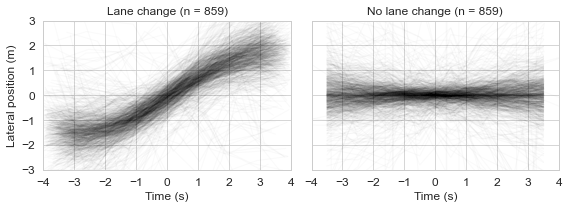

In [32]:
sns.set_style('whitegrid')
fig, axs = plt.subplots(1,2,figsize=(8,3),sharey=True)
for fragment_pos in fragments_positive:
    axs[0].plot(fragment_pos.t_fragment, fragment_pos.offset_pos-fragment_pos.offset_pos.mean() , alpha=0.02, c='k')#-fragment_pos.offset_pos.loc[abs(fragment_pos.t_fragment).idxmin()]
    axs[0].set_ylim(-3,3)
for fragment_neg in fragments_negative:
    axs[1].plot(fragment_neg.t_fragment, fragment_neg.offset-fragment_neg.offset.mean() , alpha=0.02, c='k')
    
axs[0].set_xlim(-window_size/2,window_size/2)
axs[1].set_xlim(-window_size/2,window_size/2)
axs[0].set_title(f'Lane change (n = {len(fragments_positive)})', size=12)
axs[1].set_title(f'No lane change (n = {len(fragments_negative)})',size=12)
# plt.xticks(fontsize=12)
# plt.yticks(fontsize=12)
axs[0].tick_params(axis='y', labelsize=12 )
axs[0].tick_params(axis='x', labelsize=12 )
axs[1].tick_params(axis='x', labelsize=12 )
axs[0].set_xlabel('Time (s)', size=12)
axs[1].set_xlabel('Time (s)', size=12)
axs[0].set_ylabel('Lateral position (m)', size=12)
# axs[0].text(-0.2,-2.8,"$t_{LC}$",size=14)
# plt.grid(axis='y')
# axs[0].set_xticklabels(['$-3$','$-2$','$-1$', '$0t_{LC}$', '$1$', '$2$', '$3$'])
plt.tight_layout()
axs[0].xaxis.set_ticks(np.arange(-4,5,1))
axs[1].xaxis.set_ticks(np.arange(-4,5,1))
plt.savefig('figures/positive_negative_fragments2.png', dpi=2000, bbox_inches='tight')

# A closer look at false predictions

Generate lists with fragments that were incorrectly classified. The csv's were exported and analysed in QGIS

In [35]:
window_size=6
min_dist = 5 # for baseline, only consider intervals that are at least min_dist seconds away from a lane change annotation
sections = 'all'
signal_col = 'offset'
threshold = 1.5
dev_nr = 4 #1,3,4
trip_nr = 2
# baseline_fragments_dev = extract_baseline_fragments_alltrips(signal_col, trip_dfs, trip_names, lca_dfs, dev_nr, sections, window_size, min_dist)
# lanechange_fragments_dev = extract_lanechange_fragments_alltrips(signal_col, trip_dfs, trip_names, lca_dfs, dev_nr, sections, window_size)
# lanechange_fragments_dev = make_lanechange_fragments_unidirectional(lanechange_fragments_dev,signal_col)
trip_df, lca_df, trip_name = selector(trip_dfs, lca_dfs, trip_names, trip_nr, dev_nr, sections)
fragments_positive = extract_lanechange_fragments_trip(signal_col, trip_df, lca_df, window_size)
baseline_fragments = extract_baseline_fragments_trip(signal_col, trip_df, lca_df, window_size, min_dist)
fragments_positive = make_lanechange_fragments_unidirectional(fragments_positive,signal_col)
# get same amount of negative traces as positive traces
random.seed(42)
fragments_negative = random.sample(baseline_fragments, len(fragments_positive))

y_true,y_predict, TP, FP, TN, FN, accuracy,TPR,FPR = get_results(fragments_positive, fragments_negative, threshold)



y_df = pd.DataFrame({'y_true':y_true, 'y_predict': y_predict})
y_df['FP'] = (y_df.y_true==0)&(y_df.y_predict==1)
y_df['FN'] = (y_df.y_true==1)&(y_df.y_predict==0)
y_df_pos = y_df[y_df.y_true==1]
y_df_neg = y_df[y_df.y_true==0].reset_index(drop=True)

FN_idxs = y_df_pos[y_df_pos.FN==True].index
FP_idxs = y_df_neg[y_df_neg.FP==True].index

FN_fragments = [fragments_positive[x] for x in FN_idxs]
FP_fragments = [fragments_negative[x] for x in FP_idxs]

# pd.concat(FN_fragments).to_csv(f'results/FN_fragments_dev{dev_nr}_trip{trip_nr+1}.csv')
# pd.concat(FP_fragments).to_csv(f'results/FP_fragments_dev{dev_nr}_trip{trip_nr+1}.csv')

# Plot for figure 3

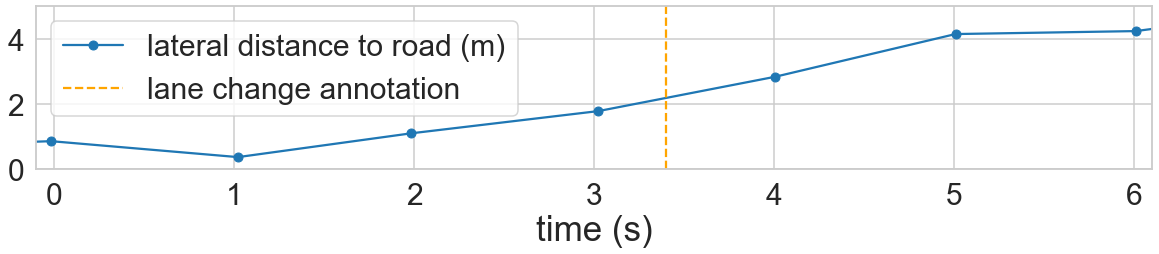

In [36]:
sns.set_style('whitegrid')
sns.set_context('talk')
fig,ax=plt.subplots(figsize=(20,3))
trip_df = trip_dfs[2][1]
fragment = trip_df[trip_df.t.between(1414,1423)]
plt.plot(fragment.t-fragment.t.iloc[0]-1, fragment.offset, marker = 'o', label='lateral distance to road (m)')
ax.set_ylim(0,5)
ax.set_xlim(-.1,6.1)
plt.xticks(fontsize= 30)
plt.yticks(fontsize= 30)
ax.set_xlabel('time (s)', size=35)
# ax.set_ylabel('lateral\ndist. (m)', size=35) 
ax.axvline(3.4, c='orange', label = 'lane change annotation', linestyle='--')
ax.legend(prop={'size': 30})

plt.savefig('figures/lateral_dist_methods_with_annotation.png', dpi=60, bbox_inches='tight')